[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

# 有监督的突变效应预测
为每个突变序列获取一个embedding（固定维度的向量表示）。在 sklearn 中训练一个回归模型，该模型可以根据embedding预测突变效应。


# 先获得每一条序列的embedding.
```
python extract.py esm1v_t33_650M_UR90S_1 P62593.fasta P62593_emb_esm1v/ --repr_layers 33 --include mean
```


In [29]:
# 在P62593_emb_esm1v文件夹里面获得每一个序列的embedding
import torch
fn = 'P62593_emb_esm1v/0|beta-lactamase_P20P|1.581033423.pt'
embs = torch.load(fn)
embs

{'label': '0|beta-lactamase_P20P|1.581033423',
 'mean_representations': {33: tensor([-0.3005,  0.1352,  0.0059,  ...,  0.0550,  0.1729,  0.0209])}}

In [30]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

import esm

In [31]:
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [32]:
FASTA_PATH = "P62593.fasta" # Path to P62593.fasta
EMB_PATH = "P62593_emb_esm1v" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 33

加载嵌入向量（Xs）和目标label（ys）。
我们的FASTA文件格式如下：
{index}|{mutation_id}|{effect}
{seq}
我们将从每个条目中提取效应值（effect）。
我们的嵌入向量存储在以后缀为.pt的文件中，文件名由FASTA头信息构成：{index}|{mutation_id}|{effect}.pt。

In [33]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

5297
(5297, 1280)


### Train / Test Split

80%训练数据

In [34]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)



In [35]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((4237, 1280), (1060, 1280), 4237, 1060)

In [48]:
sum(Xs)

array([-1591.5022  ,   718.5775  ,    35.644257, ...,   292.01135 ,
         909.8674  ,   111.11202 ], dtype=float32)

### PCA
主成分分析（Principal Component Analysis, PCA）是一种常用的降维技术。
给定原始特征数 n_features（在我们的例子中是 1280），PCA 会计算出一组新的特征向量 X，这些新特征能够**“最好地解释原始数据”**。
研究发现，经过 PCA 处理后，后续的模型训练速度会更快，同时性能损失非常小。

在这里，我们将主成分数设置为 60（num_pca_components = 60），
但你也可以根据需要自由调整！


可视化嵌入（Visualize Embeddings）

接下来，我们将前两个主成分绘制在二维坐标系中，
即第一个主成分作为 x 轴，第二个主成分作为 y 轴。
每个点的颜色表示其缩放后的效应值（scaled effect）——也就是我们想要预测的目标变量。

从图中可以直观看到，点的颜色（或效应）之间存在一定的分离趋势，
这说明我们的表示（embeddings）对于该任务是有区分度的，
即使在没有针对任务进行特定训练的情况下，也能体现出一定的有效性。

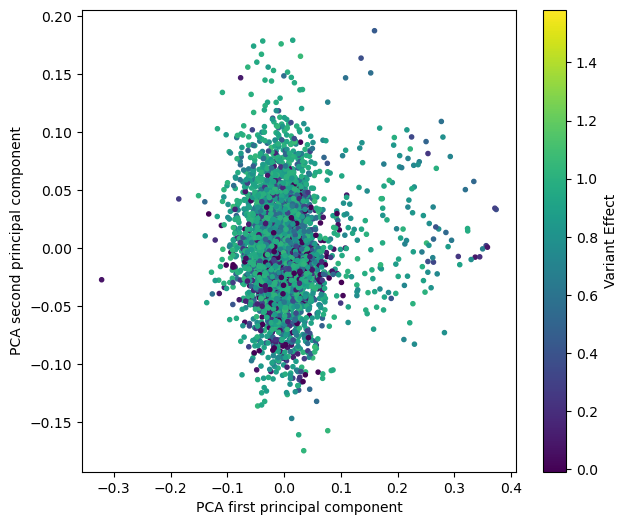

In [58]:
num_pca_components = 2
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

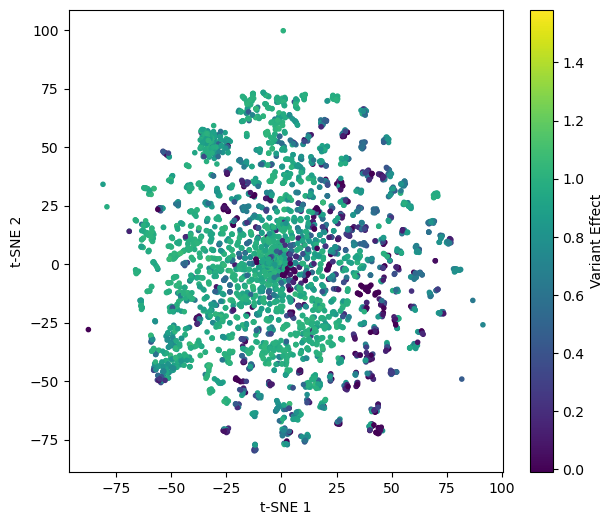

In [60]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42,init='random')
Xs_train_pca = tsne.fit_transform(Xs_train)
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.colorbar(sc, label='Variant Effect')

初始化与运行网格搜索（Grid Search）

我们将针对三种不同的**回归模型（regression models）**运行网格搜索（Grid Search）：

K 最近邻（K-nearest-neighbors, KNN）

支持向量机（Support Vector Machine, SVM）

随机森林回归（Random Forest Regressor）

在这里，我们将使用 经过 PCA 降维后的特征（PCA-projected features），
因为实验发现它在性能上与原始特征 Xs 相当，
但可以显著加快训练速度。


为不同的回归方法初始化参数网格（Initialize grids for different regression techniques）

接下来，我们将为每一种回归算法定义其对应的参数搜索网格（parameter grid），
供 GridSearchCV 使用，以便自动搜索最佳超参数组合。

In [38]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

### Run Grid Search 

(will take a few minutes on a single core)

In [50]:
# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)

    pipe = Pipeline([
        ('pca', PCA(num_pca_components)),
        ('model', cls_name())
    ])


    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
# 举个例子
# 这样 Pipeline 在训练时自动：
# 用训练数据拟合 PCA；
# 用降维后的特征训练 KNN；
# 在预测时自动对新数据做相同的 PCA transform，再预测。
# 防止数据泄露：PCA 的 fit 只会用训练集计算特征空间，而不会用到测试集。
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([
    ('pca', PCA(n_components=60)),
    ('model', KNeighborsRegressor(n_neighbors=5))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

<a id='browse'></a>
## Browse the Sweep Results

The following tables show the top 5 parameter settings, based on `mean_test_score`. Given our setup, this should really be thought of as `validation_score`.

### K Nearest Neighbors

In [51]:
result_list[0].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.193310,0.011741,0.219043,0.005022,KNeighborsRegressor(),brute,30,5,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",0.666166,0.610895,0.683070,0.706147,0.658017,0.664859,0.031613,1
1,0.503677,0.052112,0.264460,0.014342,KNeighborsRegressor(),ball_tree,15,5,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",0.674976,0.612360,0.679994,0.698832,0.657974,0.664827,0.029289,2
33,0.187165,0.005992,0.252940,0.003604,KNeighborsRegressor(),brute,15,5,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",0.666568,0.611380,0.677847,0.705649,0.656689,0.663627,0.030837,3
17,0.676653,0.112221,0.411743,0.079643,KNeighborsRegressor(),kd_tree,15,5,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",0.671229,0.604321,0.673523,0.701691,0.654557,0.661064,0.032160,4
9,0.702444,0.128603,0.269186,0.044040,KNeighborsRegressor(),ball_tree,30,5,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",0.674822,0.606232,0.659555,0.704787,0.659507,0.660981,0.031975,5


### SVM

In [42]:
result_list[1].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.614952,0.058961,0.000760,0.000143,SVR(),0.1,3,scale,linear,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.540278,0.081778,0.000958,0.000221,SVR(),0.1,3,scale,poly,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.569700,0.082890,0.000851,0.000297,SVR(),0.1,3,scale,rbf,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0.573088,0.077616,0.000682,0.000128,SVR(),0.1,3,scale,sigmoid,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0.545999,0.194311,0.000748,0.000242,SVR(),1.0,3,scale,linear,"{'model': SVR(), 'model__C': 1.0, 'model__degr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### Random Forest

In [43]:
result_list[2].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__criterion,param_model__max_features,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.484106,0.226126,0.001550,0.000636,RandomForestRegressor(),squared_error,sqrt,1,5,20,"{'model': RandomForestRegressor(), 'model__cri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.492783,0.155634,0.001570,0.000284,RandomForestRegressor(),squared_error,sqrt,1,10,20,"{'model': RandomForestRegressor(), 'model__cri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.561915,0.189497,0.001819,0.001054,RandomForestRegressor(),squared_error,sqrt,4,5,20,"{'model': RandomForestRegressor(), 'model__cri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0.592376,0.194218,0.001425,0.000252,RandomForestRegressor(),squared_error,sqrt,4,10,20,"{'model': RandomForestRegressor(), 'model__cri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0.690137,0.031615,0.001643,0.000503,RandomForestRegressor(),squared_error,log2,1,5,20,"{'model': RandomForestRegressor(), 'model__cri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [52]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')


KNeighborsRegressor(algorithm='brute', p=1, weights='distance')

SignificanceResult(statistic=0.8114970263599901, pvalue=4.2201716278134004e-249)

 -------------------------------------------------------------------------------- 

SVR()

SignificanceResult(statistic=0.8287107189047642, pvalue=6.151545692753756e-269)

 -------------------------------------------------------------------------------- 

RandomForestRegressor(max_features='log2', min_samples_split=5, n_estimators=20)

SignificanceResult(statistic=0.7244339517443475, pvalue=3.9324041642517954e-173)

 -------------------------------------------------------------------------------- 



In [ ]:
# 以下是使用 Python（SciPy 和 NumPy）计算 Spearman 相关系数的示例：
from scipy.stats import spearmanr
import numpy as np

# 示例数据：预测分数和实验值
predicted_scores = [0.1, 0.5, 0.3, 0.8, 0.2]  # ESM-1v 预测的突变效应
true_scores = [0.2, 0.4, 0.3, 0.7, 0.1]      # 实验测量的效应

# 计算 Spearman 相关系数
rho, p_value = spearmanr(predicted_scores, true_scores)

print(f"Spearman 相关系数: {rho:.3f}")
print(f"p 值: {p_value:.3f}")